In [3]:
#Import dependencies required for that job.
import pandas as pd
import matplotlib.pylab as plt 
import numpy as np
import requests
from config import geoapify_key
import json
import hvplot.pandas
from scipy.stats import linregress
import scipy.stats as stats

In [4]:
# importing table which contain used cars lot in Canada and performing some cleaning on the data
data_df = pd.read_csv("Dataset/ca-dealers-used.csv")
count = data_df['state'].value_counts()
data_df['state'] = data_df['state'].replace({"OH" : "ON", "SC" :"QC",})
data_df = data_df[data_df['state']!= "WA"]
data_df.head()

/var/folders/qh/th17k7b126bdp6fpt44nzdb80000gn/T/ipykernel_1753/4048503583.py:2: DtypeWarning: Columns (13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv("Dataset/ca-dealers-used.csv")


,id,vin,price,miles,stock_no,year,make,model,trim,body_type,...,drivetrain,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip
0,b39ea795-eca9,19UNC1B01HY800062,179999.0,9966.0,V-P4139,2017.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,edmundston honda,475 Rue Victoria,Edmundston,NB,E3V 2K7
1,026cb5b1-6e3e,19UNC1B02HY800023,179995.0,5988.0,PPAP70374,2017.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,garage daniel lessard,2795 Route-du-prsident-kennedy,Notre-dame-des-pins,QC,G0M 1K0
2,5cd5d5b2-5cc2,19UNC1B02HY800071,168528.0,24242.0,B21085,2017.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,lougheed acura,1388 Lougheed Highway,Coquitlam,BC,V3K 6S4
3,b32473ed-5922,19UNC1B02LY800001,220000.0,6637.0,AP5333,2020.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,drive autogroup,1305 Parkway Suite 600,Pickering,ON,L1V 3P2
4,ac40c9fc-0676,19UNC1B02LY800001,220000.0,6637.0,AP5333,2020.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,acura pickering,575 Kingston Road,Pickering,ON,L1V 3N7


In [5]:
# Selecting the speific columns that we are interested in for our analysis 
clean_df = data_df[["make","model","year","fuel_type","miles","price","engine_size","body_type","city","state"]]
clean_df.head()

,make,model,year,fuel_type,miles,price,engine_size,body_type,city,state
0,Acura,NSX,2017.0,Electric / Premium Unleaded,9966.0,179999.0,3.5,Coupe,Edmundston,NB
1,Acura,NSX,2017.0,Electric / Premium Unleaded,5988.0,179995.0,3.5,Coupe,Notre-dame-des-pins,QC
2,Acura,NSX,2017.0,Electric / Premium Unleaded,24242.0,168528.0,3.5,Coupe,Coquitlam,BC
3,Acura,NSX,2020.0,Electric / Premium Unleaded,6637.0,220000.0,3.5,Coupe,Pickering,ON
4,Acura,NSX,2020.0,Electric / Premium Unleaded,6637.0,220000.0,3.5,Coupe,Pickering,ON


In [6]:
# Reading the second data set which has the fuel consumption of cars.
data_2_df = pd.read_csv("Dataset/Fuel_Consumption_2000-2022.csv")
data_2_df.head()


,YEAR,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS
0,2000,ACURA,1.6EL,COMPACT,1.6,4,A4,X,9.2,6.7,8.1,35,186
1,2000,ACURA,1.6EL,COMPACT,1.6,4,M5,X,8.5,6.5,7.6,37,175
2,2000,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,12.2,7.4,10.0,28,230
3,2000,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Z,13.4,9.2,11.5,25,264
4,2000,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,10.0,7.0,8.6,33,198


In [7]:
# Cleaning the data and adjusting column values so that the data can be related to easily
data_2_df = data_2_df[["YEAR", "MAKE", "MODEL","FUEL","FUEL CONSUMPTION", "HWY (L/100 km)","COMB (L/100 km)", "COMB (mpg)", "EMISSIONS"]]
data_2_df = data_2_df.rename(columns={"MODEL":"model","MAKE":"make","YEAR":"year","FUEL": "fuel_type"})
data_2_df['fuel_type'] = data_2_df['fuel_type'].replace({'X': 'Unleaded','Z' : 'Premium Unleaded', 'E' : 'Electric','D' : 'Diesel'})
data_2_df.head()

,year,make,model,fuel_type,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS
0,2000,ACURA,1.6EL,Unleaded,9.2,6.7,8.1,35,186
1,2000,ACURA,1.6EL,Unleaded,8.5,6.5,7.6,37,175
2,2000,ACURA,3.2TL,Premium Unleaded,12.2,7.4,10.0,28,230
3,2000,ACURA,3.5RL,Premium Unleaded,13.4,9.2,11.5,25,264
4,2000,ACURA,INTEGRA,Unleaded,10.0,7.0,8.6,33,198


In [8]:
# Performing a merge on the 2 datasets on specific columns.
merge_df = pd.merge(clean_df,data_2_df,how = "outer",on = ["make","model","year","fuel_type"])
merge_df.head()

,make,model,year,fuel_type,miles,price,engine_size,body_type,city,state,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS
0,Acura,NSX,2017.0,Electric / Premium Unleaded,9966.0,179999.0,3.5,Coupe,Edmundston,NB,NaN,NaN,NaN,NaN,NaN
1,Acura,NSX,2017.0,Electric / Premium Unleaded,5988.0,179995.0,3.5,Coupe,Notre-dame-des-pins,QC,NaN,NaN,NaN,NaN,NaN
2,Acura,NSX,2017.0,Electric / Premium Unleaded,24242.0,168528.0,3.5,Coupe,Coquitlam,BC,NaN,NaN,NaN,NaN,NaN
3,Acura,NSX,2017.0,Electric / Premium Unleaded,18281.0,155771.0,3.5,Coupe,Montral,QC,NaN,NaN,NaN,NaN,NaN
4,Acura,NSX,2017.0,Electric / Premium Unleaded,18281.0,155771.0,3.5,Coupe,Montral,QC,NaN,NaN,NaN,NaN,NaN


In [9]:
#importing 3 table as a csv - this will allow associate cars with the respective countries
manufacturer_df = pd.read_csv("Dataset/manufacturers.csv")
manufacturer_df["make"] = manufacturer_df["make"].str.title()

# merging the 3 table with the previous merge 
final_df = pd.merge(merge_df,manufacturer_df[["make","country"]],on = "make")
final_df = final_df.dropna()
final_df.head()


,make,model,year,fuel_type,miles,price,engine_size,body_type,city,state,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS,country
1793,Acura,ILX,2018.0,Premium Unleaded,39000.0,19999.0,2.4,Sedan,London,ON,9.4,6.8,8.2,34.0,192.0,Japan
1794,Acura,ILX,2018.0,Premium Unleaded,25661.0,23240.0,2.4,Sedan,Halifax,NS,9.4,6.8,8.2,34.0,192.0,Japan
1795,Acura,ILX,2018.0,Premium Unleaded,21675.0,20999.0,2.4,Sedan,Chatham-kent,ON,9.4,6.8,8.2,34.0,192.0,Japan
1796,Acura,ILX,2018.0,Premium Unleaded,21675.0,21999.0,2.4,Sedan,Leamington,ON,9.4,6.8,8.2,34.0,192.0,Japan
1797,Acura,ILX,2018.0,Premium Unleaded,32144.0,22776.0,2.4,Sedan,Montral,QC,9.4,6.8,8.2,34.0,192.0,Japan


In [10]:
#considering only cars between 2017 and 2022 & renaming the columns to make the data look presentable.

final_tweak_df = final_df.loc[(final_df["year"] >= 2017) & (final_df["year"] <= 2022),:]
final_tweak_df.rename(columns={'make': 'BRAND', 'model':'MODEL', 'year':'YEAR','fuel_type':'FUEL TYPE',
                       'state':'STATE', 'miles':'MILES','price': 'PRICE', 'engine_size':'ENGINE SIZE',	
                       'body_type':'BODY TYPE', 'city':'CITY','country':'COUNTRY'}, inplace=True)                      
final_tweak_df.head()

,BRAND,MODEL,YEAR,FUEL TYPE,MILES,PRICE,ENGINE SIZE,BODY TYPE,CITY,STATE,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS,COUNTRY
1793,Acura,ILX,2018.0,Premium Unleaded,39000.0,19999.0,2.4,Sedan,London,ON,9.4,6.8,8.2,34.0,192.0,Japan
1794,Acura,ILX,2018.0,Premium Unleaded,25661.0,23240.0,2.4,Sedan,Halifax,NS,9.4,6.8,8.2,34.0,192.0,Japan
1795,Acura,ILX,2018.0,Premium Unleaded,21675.0,20999.0,2.4,Sedan,Chatham-kent,ON,9.4,6.8,8.2,34.0,192.0,Japan
1796,Acura,ILX,2018.0,Premium Unleaded,21675.0,21999.0,2.4,Sedan,Leamington,ON,9.4,6.8,8.2,34.0,192.0,Japan
1797,Acura,ILX,2018.0,Premium Unleaded,32144.0,22776.0,2.4,Sedan,Montral,QC,9.4,6.8,8.2,34.0,192.0,Japan


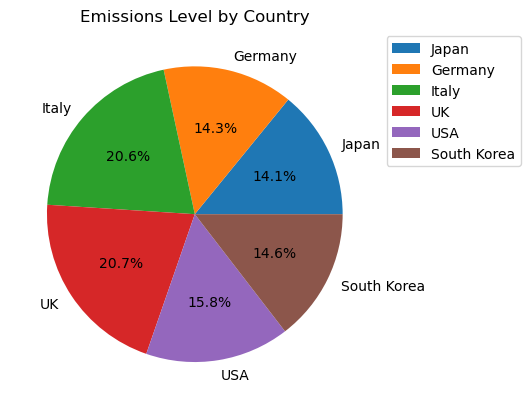

In [11]:
# Generate the mean of emissions level in each country
country_grp_df = final_tweak_df.set_index('COUNTRY')
japan_cars_df = country_grp_df.loc['Japan']['EMISSIONS'].mean()
germany_cars_df = country_grp_df.loc['Germany']['EMISSIONS'].mean()
italy_cars_df = country_grp_df.loc['Italy']['EMISSIONS'].mean()
uk_cars_df = country_grp_df.loc['UK']['EMISSIONS'].mean()
usa_cars_df = country_grp_df.loc['USA']['EMISSIONS'].mean()
korea_cars_df = country_grp_df.loc['South Korea']['EMISSIONS'].mean()
total_emissions = [japan_cars_df, germany_cars_df, italy_cars_df, uk_cars_df, usa_cars_df, korea_cars_df]

countries = ['Japan', 'Germany', 'Italy', 'UK', 'USA', 'South Korea']
total_emissions_df = pd.DataFrame({'Emissions': total_emissions}, index=countries)

# Plot the pie chart
ax = total_emissions_df.plot(kind='pie', y='Emissions', autopct='%1.1f%%', title ='Emissions Level by Country',ylabel='')

# Move the legend outside the chart
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
          
# Display the chart
plt.show()

In [12]:
# Determine the main countries that we are focussing on and the popular subtypes.
country_grp_cars = final_tweak_df.groupby("COUNTRY")
country_cars = country_grp_cars['COUNTRY'].count()
print(country_cars)
country_values = final_tweak_df['BODY TYPE'].unique()
print(country_values)

COUNTRY
Germany        11835
Italy            109
Japan          34979
South Korea    27284
UK               378
USA            42629
Name: COUNTRY, dtype: int64
['Sedan' 'Coupe' 'SUV' 'Minivan' 'Pickup' 'Convertible' 'Hatchback'
 'Crossover' 'Cargo Van' 'Targa' 'Wagon']


In [13]:
# List the number of brands that we can perform the study on.
brand_cars = final_tweak_df['BRAND'].unique().tolist()
print(brand_cars)

['Acura', 'Dodge', 'Chrysler', 'Ford', 'Chevrolet', 'Buick', 'Cadillac', 'Nissan', 'Volkswagen', 'Mercedes-Benz', 'Toyota', 'Lincoln', 'Land Rover', 'Bentley', 'Audi', 'Porsche', 'Maserati', 'Honda', 'Jeep', 'Mazda', 'Hyundai', 'Kia', 'Mitsubishi', 'Subaru', 'Rolls-Royce', 'Aston Martin', 'Lamborghini', 'Alfa Romeo']


In [46]:
# To create a function to extract the country,emission and mileage for different cars based on the country.
# to plot the data in a bar chart.
def countries_analysis(dataframe,country):
    """
    Function to perform analysis and plot graphs for respective country analysis
    1. to create table of respective country with mean of emissions, Mileage in HWY and COMB
    2. create subplots of the data regarding respective country

    Input 
    Dataframe to be analyzed and the country that the car belongs to are the parameters that needs to be passed to the function

    Output
    This will return a dataframe which contains the country,emission(mean) and mileage(mean) for different cars based on the country 
    """
    country_cars_mpg = dataframe[dataframe["COUNTRY"]== country]
    emissions = country_cars_mpg.groupby('BRAND')['EMISSIONS'].mean()
    hwy = country_cars_mpg.groupby('BRAND')['HWY (L/100 km)'].mean()
    comb =  country_cars_mpg.groupby('BRAND')['COMB (L/100 km)'].mean()
    mpg = country_cars_mpg.groupby('BRAND')['COMB (mpg)'].mean()
    city_mil = country_cars_mpg.groupby('BRAND')['FUEL CONSUMPTION'].mean()
    summary = ({"COUNTRY" : emissions.index.values,
              "EMISSIONS" : (round(emissions,2)),
              "MILEAGE CITY(L/100 KM)" : round(city_mil),
              "MILEAGE HWY(L/100 KM)" : round(hwy),
              "COMB (L/100 KM)" : round(comb),
              "COMB (MPG)": round(mpg)})
    summary_df = pd.DataFrame(summary)
    summary_df.reset_index(inplace= True, drop = True)

    #converting emissions (g/km) to (L/km)
    summary_df['EMISSIONS'] = (summary_df['EMISSIONS']/(summary_df["COMB (MPG)"]*1.609/3.78))

    # resetting the index summary_df from country to numbers
    summary_df.reset_index()
    summary_short_df = summary_df[['COUNTRY','EMISSIONS','MILEAGE CITY(L/100 KM)','MILEAGE HWY(L/100 KM)','COMB (L/100 KM)']]

    # plotting graph for respective cars of a particular model
    multi_plot = summary_short_df.plot(kind="bar",figsize = (20,10),fontsize= 14)
    
    # PandasPlot.set_xticklabels() can be used to set the tick labels as well
    multi_plot.set_xticklabels(summary_short_df["COUNTRY"], rotation=45,fontsize = 20, weight = 'bold')
    multi_plot.set_ylabel("L/100 KM", fontsize = 20)
    multi_plot.set_title(f"{country} Cars  showing emisssions along with Mileage in City, Highway and COMB",fontsize = 20)
    
    # setting first label of legend 
    legend = multi_plot.legend()
    legend.get_texts()[0].set_text('Emission in L/km')

    plt.show()

    #  to ensure that everything is 
    plt.tight_layout()
    


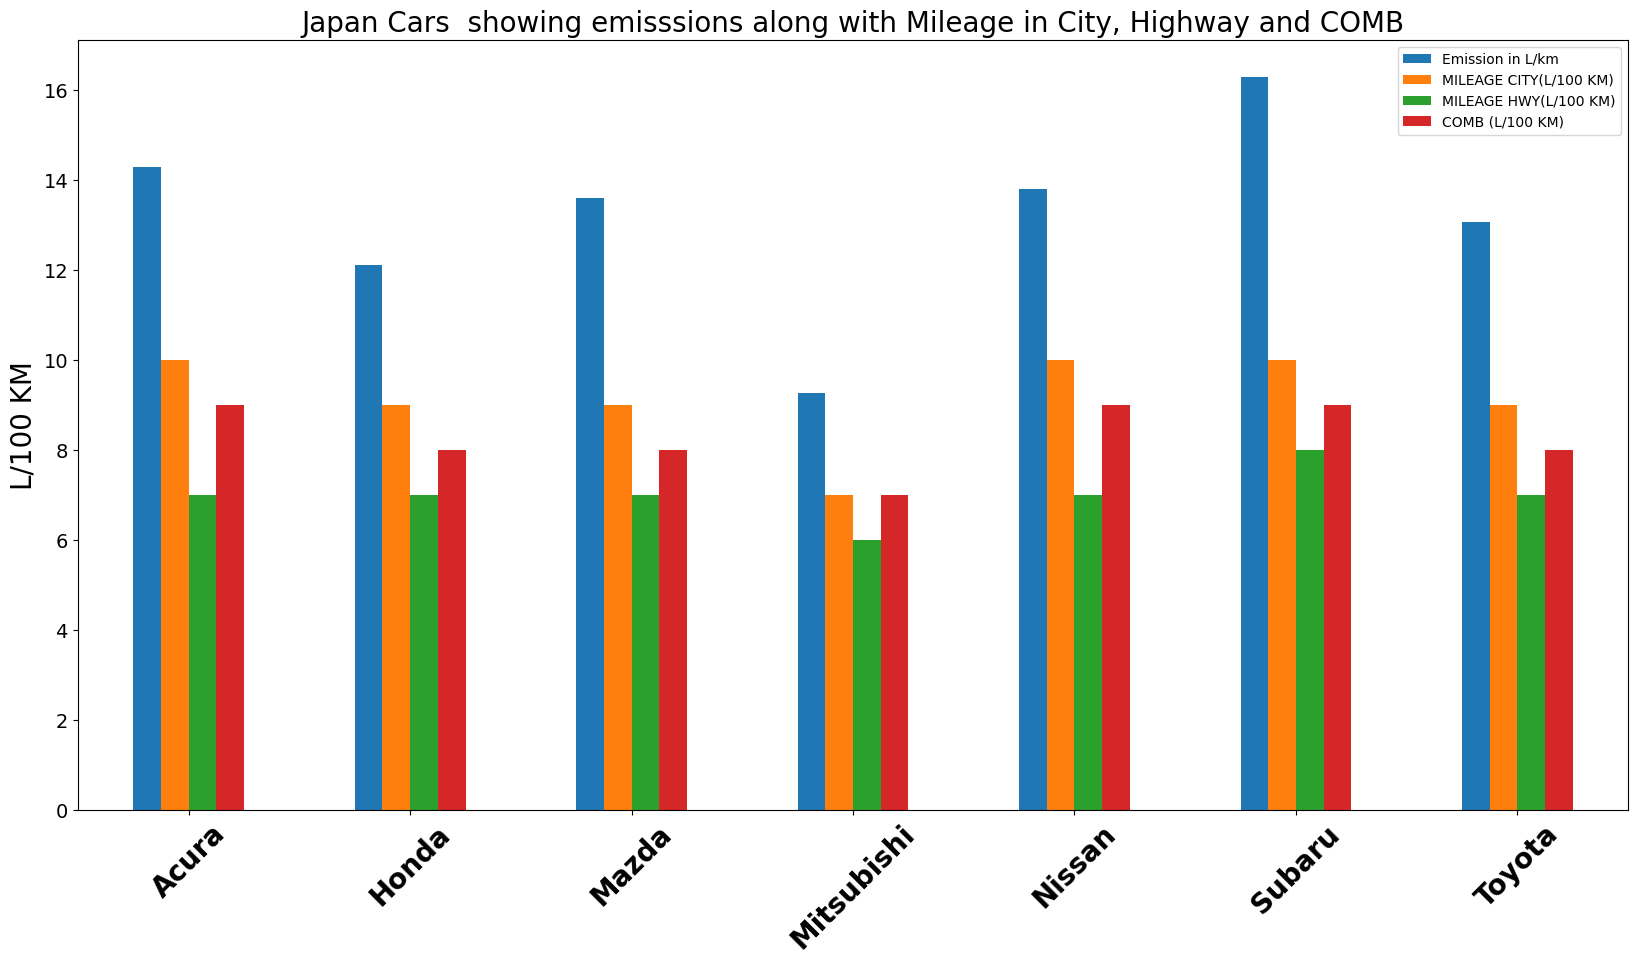

<Figure size 640x480 with 0 Axes>

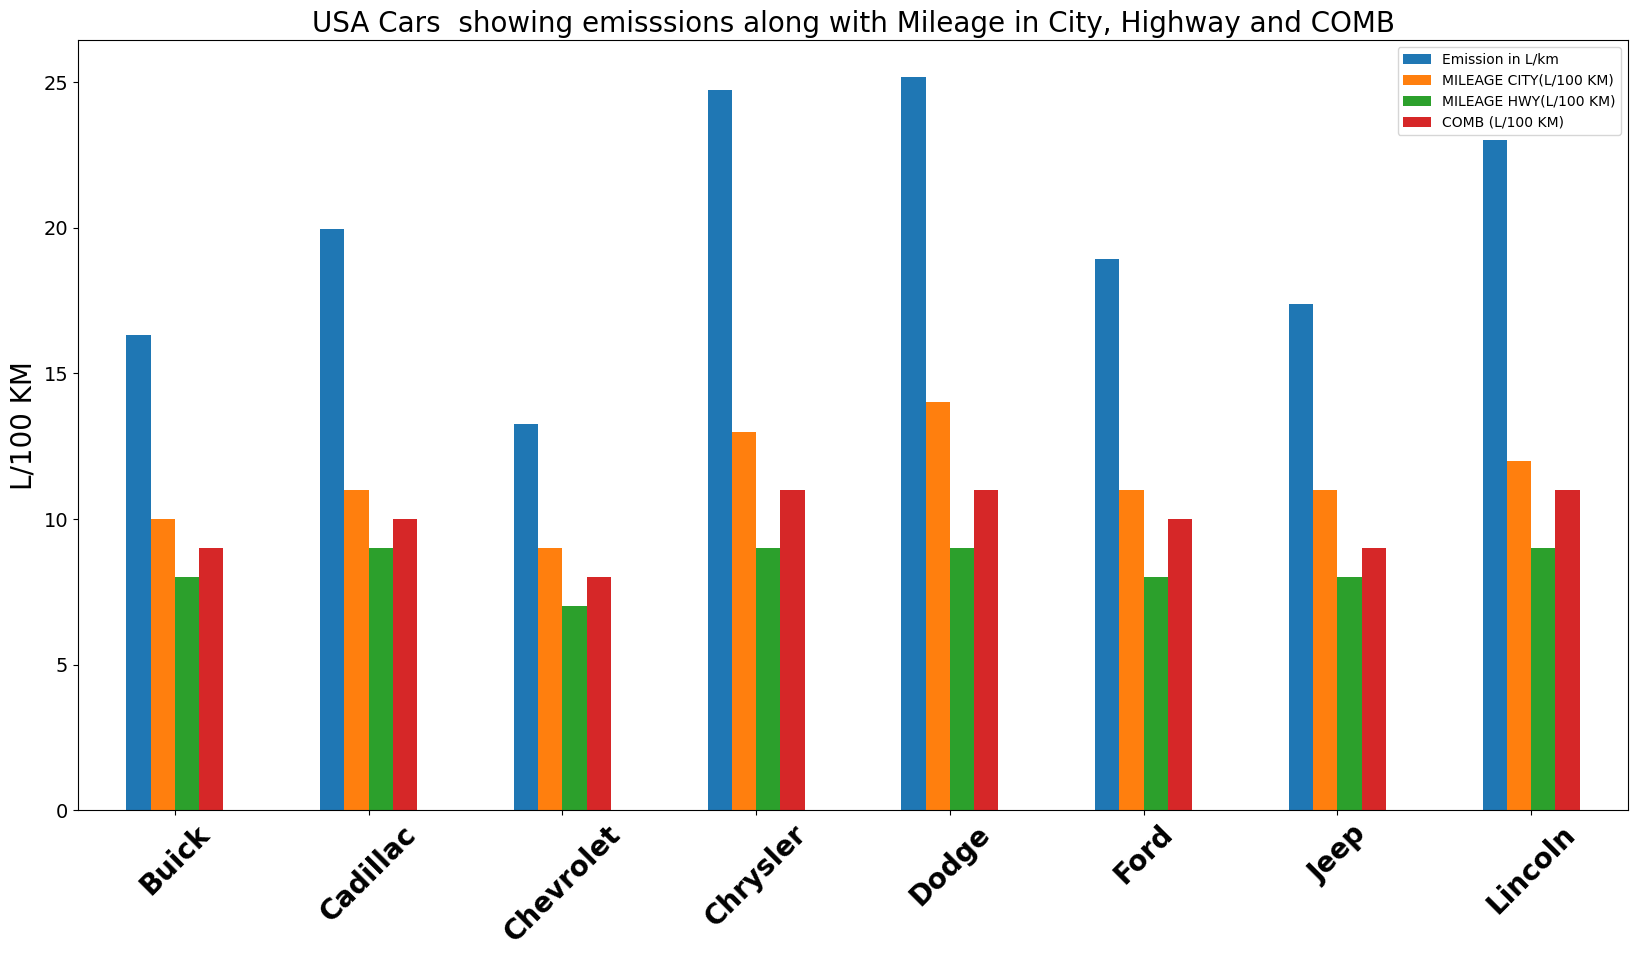

<Figure size 640x480 with 0 Axes>

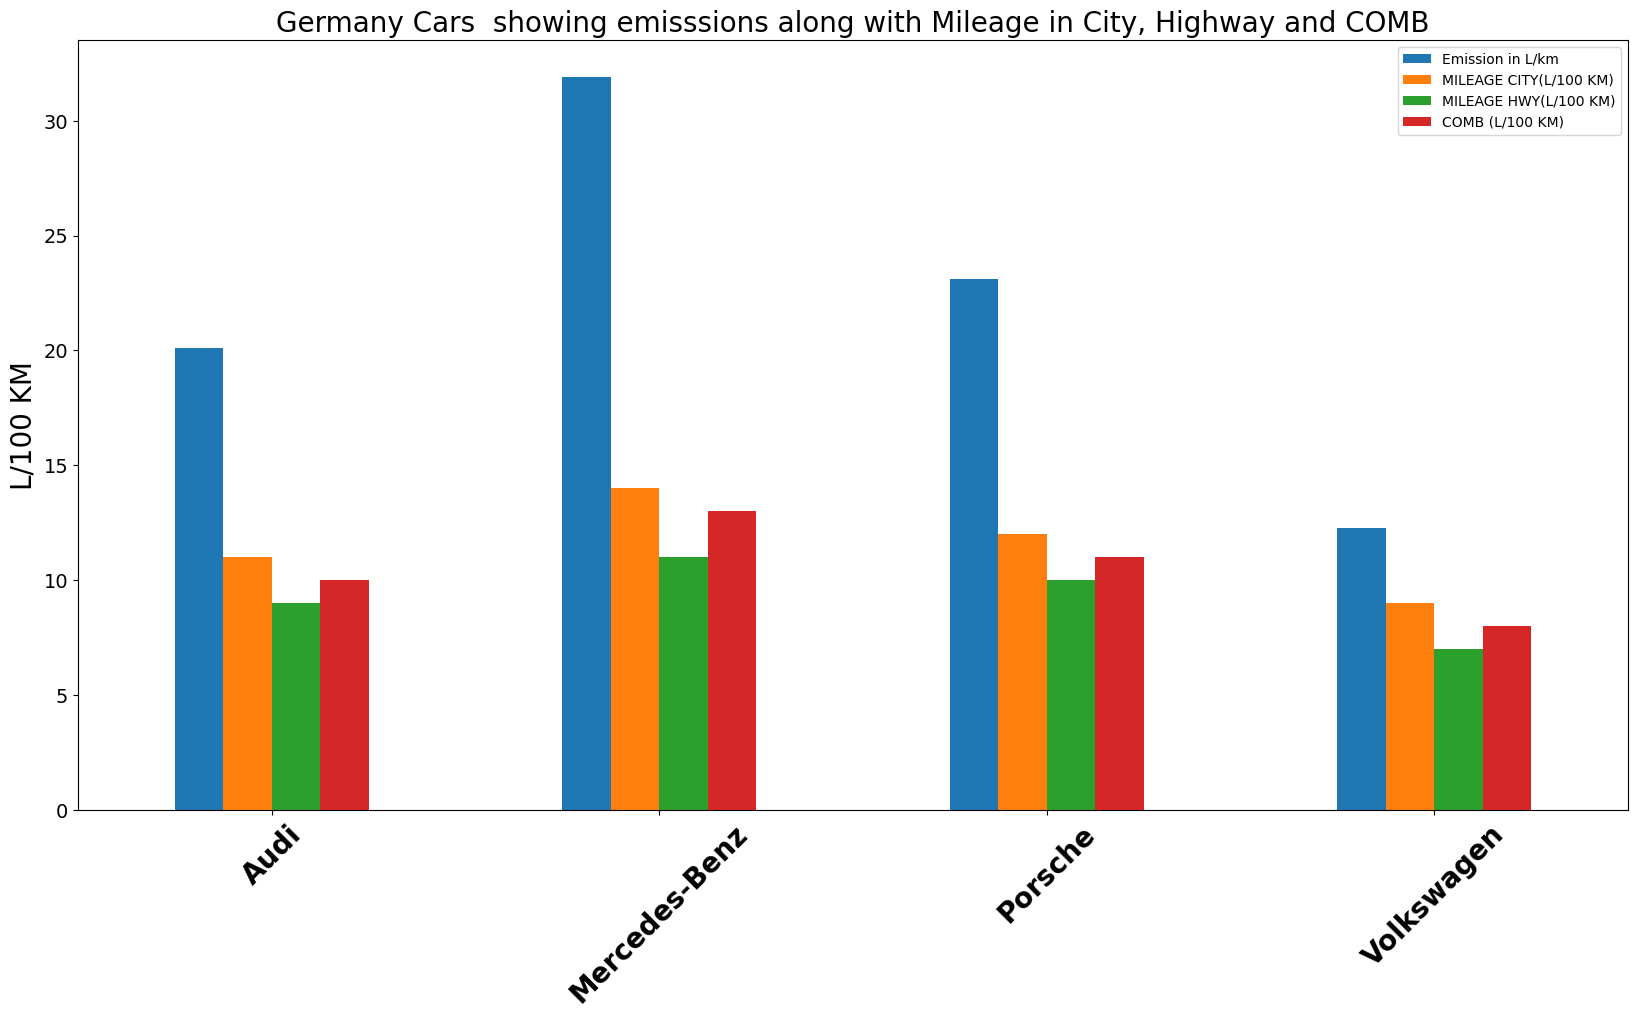

<Figure size 640x480 with 0 Axes>

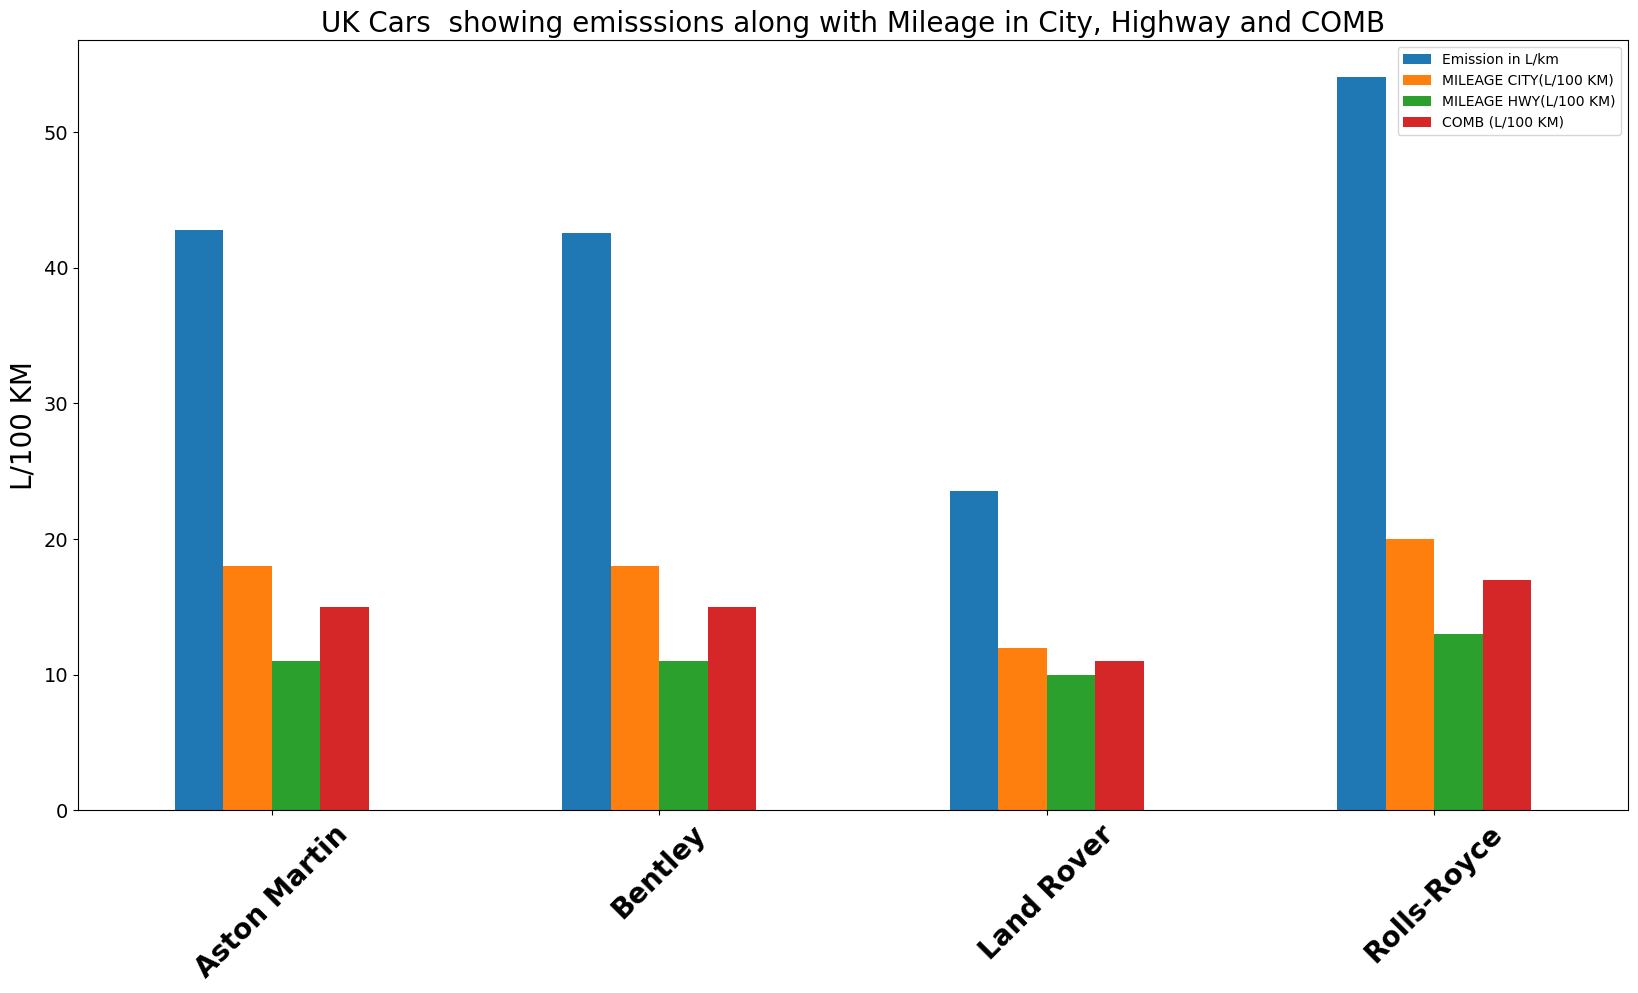

<Figure size 640x480 with 0 Axes>

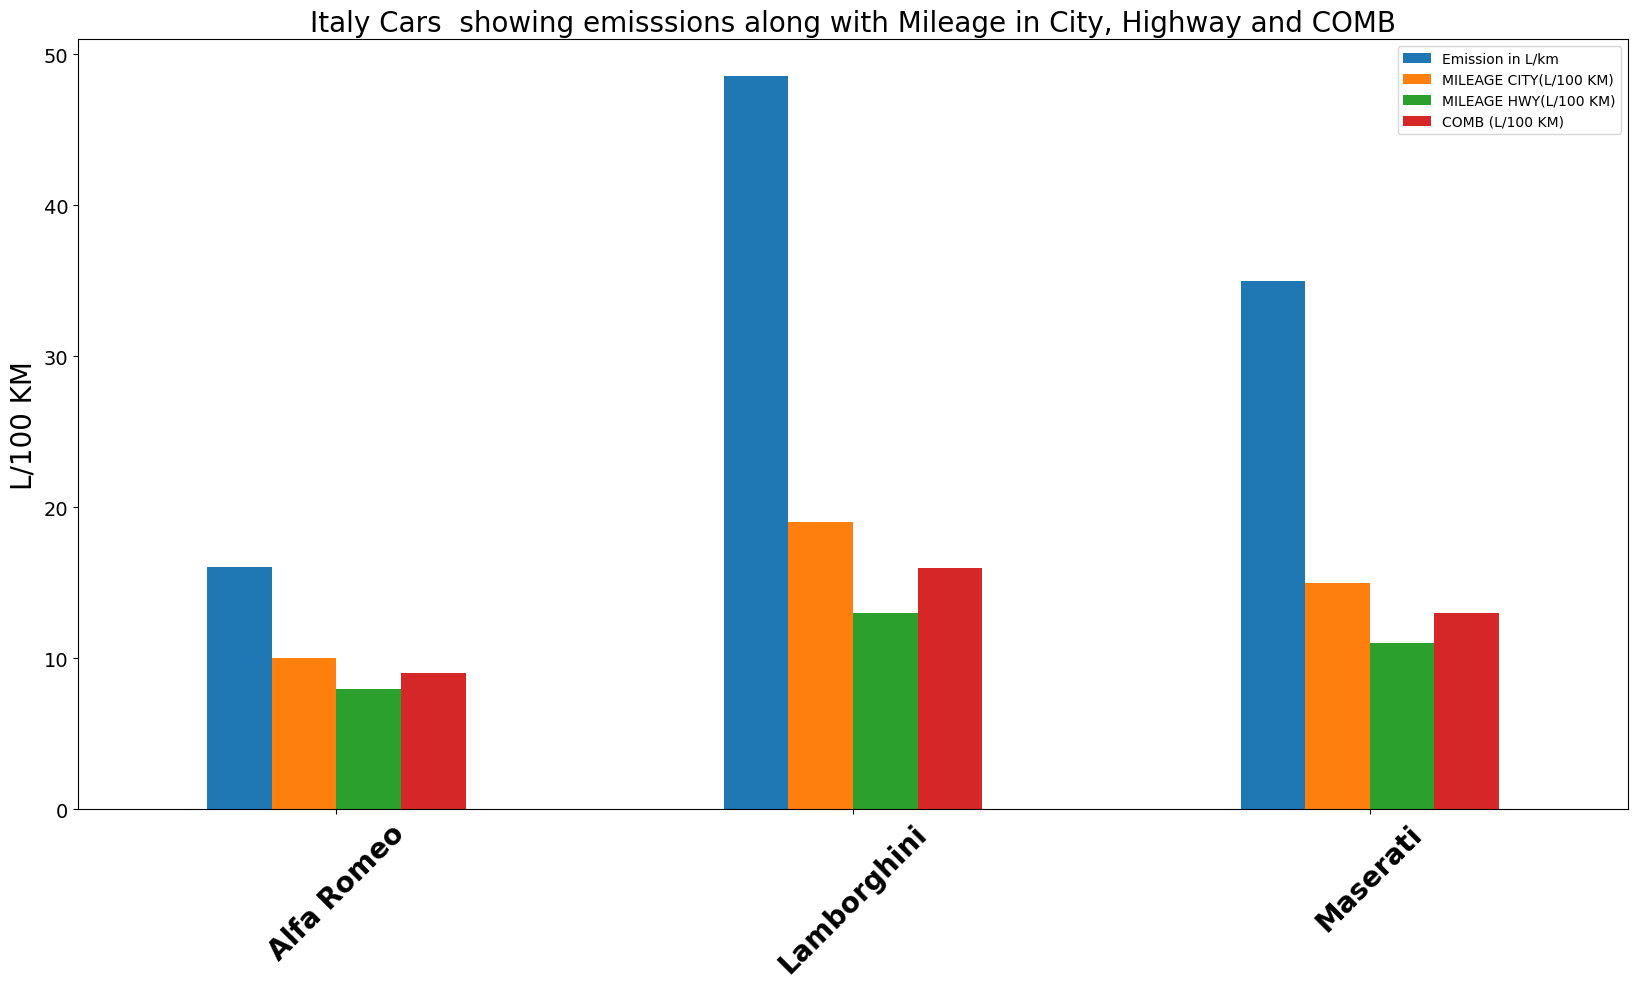

<Figure size 640x480 with 0 Axes>

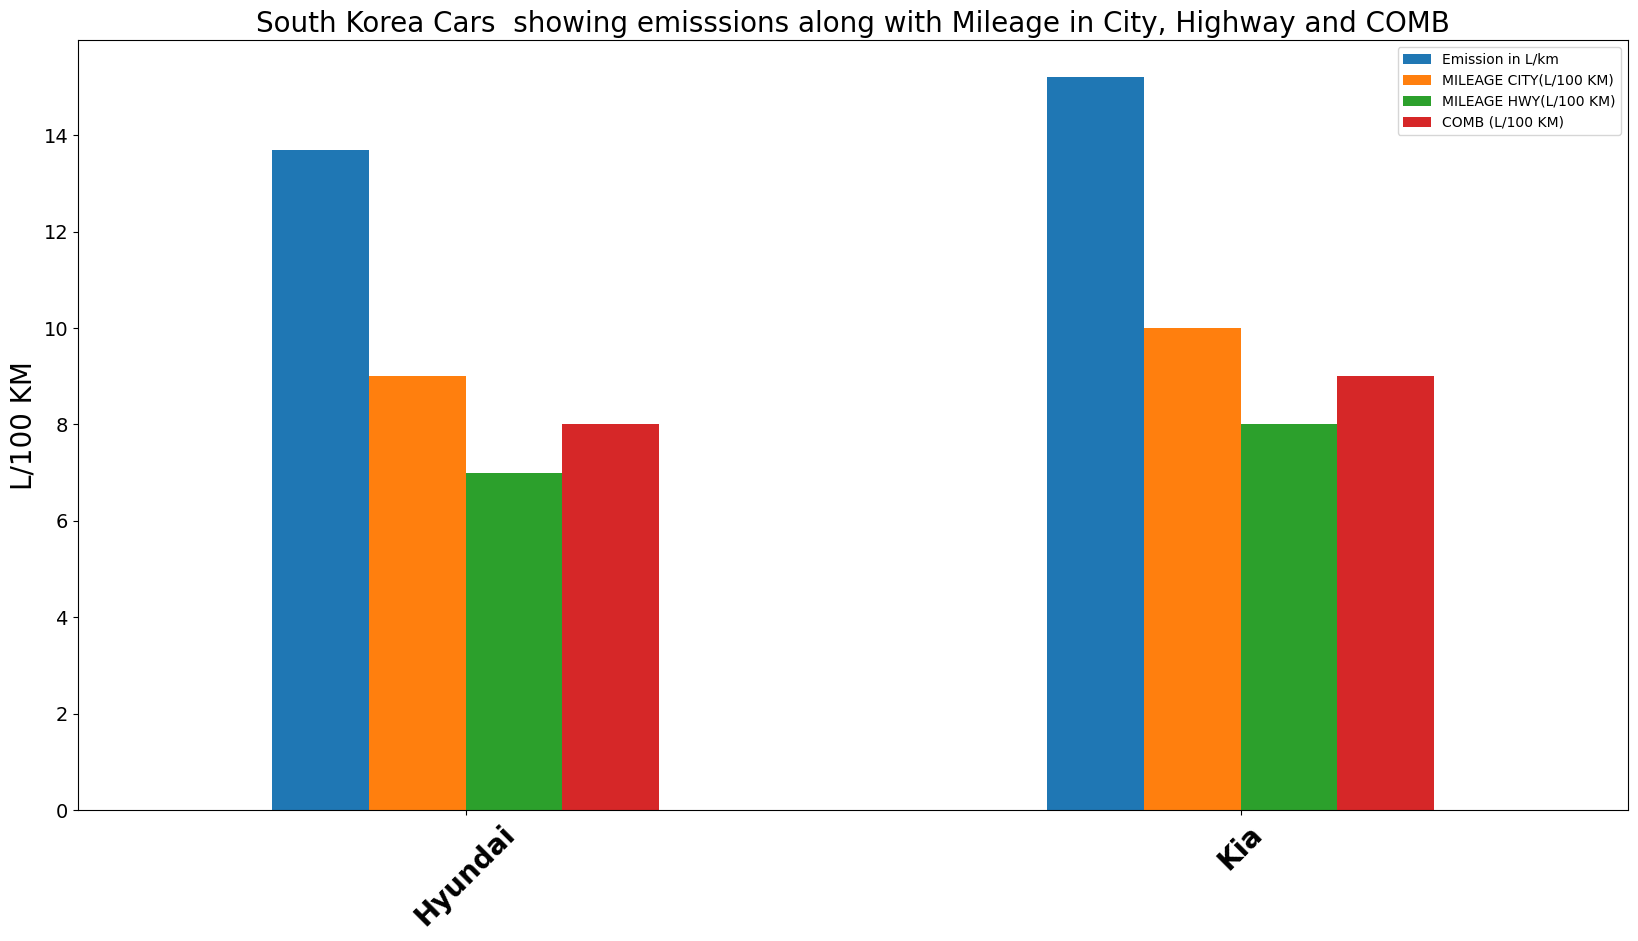

<Figure size 640x480 with 0 Axes>

In [47]:
#To create a table from the merged dataset and plot graphs
countries = final_tweak_df["COUNTRY"].unique()
for counts in countries:
    summ = countries_analysis(final_tweak_df,counts)


In [16]:
# Find out what body types of cars are most produced by all countries
car_types = country_grp_df['BODY TYPE'].value_counts()
car_types

SUV            47356
Sedan          39976
Hatchback      16871
Pickup          7936
Coupe           1651
Wagon           1511
Minivan         1225
Convertible      328
Targa            302
Crossover         41
Cargo Van         17
Name: BODY TYPE, dtype: int64

In [17]:
#Lowest emission cars
least_pol = final_tweak_df['EMISSIONS'].min()
print(least_pol)
fuel_eff = final_tweak_df.loc[final_tweak_df['EMISSIONS'] <= 141.0,:]
fuel_eff.head()

141.0


,BRAND,MODEL,YEAR,FUEL TYPE,MILES,PRICE,ENGINE SIZE,BODY TYPE,CITY,STATE,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS,COUNTRY
422753,Mitsubishi,Mirage,2018.0,Unleaded,37983.0,9995.0,1.2,Hatchback,Sarnia,ON,6.4,5.5,6.0,47.0,141.0,Japan
422755,Mitsubishi,Mirage,2018.0,Unleaded,37983.0,9995.0,1.2,Hatchback,Sarnia,ON,6.4,5.5,6.0,47.0,141.0,Japan
422757,Mitsubishi,Mirage,2018.0,Unleaded,37983.0,9995.0,1.2,Hatchback,Chatham-kent,ON,6.4,5.5,6.0,47.0,141.0,Japan
422759,Mitsubishi,Mirage,2018.0,Unleaded,37983.0,9995.0,1.2,Hatchback,Sarnia,ON,6.4,5.5,6.0,47.0,141.0,Japan
422761,Mitsubishi,Mirage,2018.0,Unleaded,22271.0,11616.0,1.2,Hatchback,Courtenay,BC,6.4,5.5,6.0,47.0,141.0,Japan


In [18]:
# Least and most polluting SUV
SUV_poll = final_tweak_df[final_tweak_df['BODY TYPE'] == 'SUV']
SUV_pol_min = SUV_poll['EMISSIONS'].min()
print(SUV_pol_min)
SUV_poll_min = SUV_poll.loc[SUV_poll['EMISSIONS']==169]
SUV_poll_min = SUV_poll_min.groupby('MODEL').head(5)
print(SUV_poll_min[['BRAND','MODEL']])
SUV_pol_max = SUV_poll['EMISSIONS'].max()
print(SUV_pol_max)
SUV_poll_max = SUV_poll.loc[SUV_poll['EMISSIONS']==386]
print(SUV_poll_max[['BRAND','MODEL']])

169.0
         BRAND  MODEL
168278  Nissan  Kicks
168279  Nissan  Kicks
168280  Nissan  Kicks
168281  Nissan  Kicks
168282  Nissan  Kicks
386.0
              BRAND     MODEL
434218  Rolls-Royce  Cullinan
434219  Rolls-Royce  Cullinan
434221  Rolls-Royce  Cullinan
434222  Rolls-Royce  Cullinan


The least polluting SUV is Nissan Kicks and most polluting SUV is the Rolls-Royce Cullinan

In [19]:
#Least and most polluting Sedan
sedan_poll = final_tweak_df[final_tweak_df['BODY TYPE'] == 'Sedan']
sedan_pol_min = sedan_poll['EMISSIONS'].min()
print(sedan_pol_min)
sedan_poll_min = sedan_poll.loc[sedan_poll['EMISSIONS']==148]
sedan_poll_min = sedan_poll_min.groupby('MODEL').head(5)
print(sedan_poll_min[['BRAND','MODEL']])
sedan_pol_max = sedan_poll['EMISSIONS'].max()
print(sedan_pol_max)
sedan_poll_max = sedan_poll.loc[sedan_poll['EMISSIONS']==397]
print(sedan_poll_max[['BRAND','MODEL']])



148.0
             BRAND      MODEL
422883  Mitsubishi  Mirage G4
422885  Mitsubishi  Mirage G4
422887  Mitsubishi  Mirage G4
422889  Mitsubishi  Mirage G4
422891  Mitsubishi  Mirage G4
397.0
              BRAND  MODEL
434156  Rolls-Royce  Ghost
434157  Rolls-Royce  Ghost


Least polluting Sedan is the Mitsubishi Mirage G4 and the most polluting is the Rolls-Royce Ghost

In [20]:
# Most polluting cars
most_pol = final_tweak_df['EMISSIONS'].max()
print(most_pol)
most_poll = final_tweak_df.loc[final_tweak_df['EMISSIONS'] == 400,:]
most_poll

400.0


,BRAND,MODEL,YEAR,FUEL TYPE,MILES,PRICE,ENGINE SIZE,BODY TYPE,CITY,STATE,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS,COUNTRY
434211,Rolls-Royce,Dawn,2020.0,Premium Unleaded,550.0,548841.0,6.6,Convertible,Laval,QC,20.4,13.1,17.1,17.0,400.0,UK
434212,Rolls-Royce,Dawn,2020.0,Premium Unleaded,550.0,548841.0,6.6,Convertible,Mont-royal,QC,20.4,13.1,17.1,17.0,400.0,UK
434213,Rolls-Royce,Dawn,2020.0,Premium Unleaded,1901.0,489900.0,6.6,Convertible,Mont-royal,QC,20.4,13.1,17.1,17.0,400.0,UK
434214,Rolls-Royce,Dawn,2020.0,Premium Unleaded,1901.0,489900.0,6.6,Convertible,Laval,QC,20.4,13.1,17.1,17.0,400.0,UK


In [21]:
# Calculate the fuel consumption of SUV and Sedan cars from Japanese brands
japanese_car_types = final_tweak_df[final_tweak_df['COUNTRY']== "Japan"]
japanese_suv = japanese_car_types[japanese_car_types['BODY TYPE'] == 'SUV']['FUEL CONSUMPTION'].mean()
japanese_sedan = japanese_car_types[japanese_car_types['BODY TYPE'] == 'Sedan']['FUEL CONSUMPTION'].mean()


In [22]:
# Calculate the fuel consumption of SUV and Sedan cars from German brands
germany_car_types = final_tweak_df[final_tweak_df['COUNTRY']== "Germany"]
germany_suv = germany_car_types[germany_car_types['BODY TYPE'] == 'SUV']['FUEL CONSUMPTION'].mean()
germany_sedan = germany_car_types[germany_car_types['BODY TYPE'] == 'Sedan']['FUEL CONSUMPTION'].mean()


In [23]:
# Calculate the fuel consumption of SUV and Sedan cars from USA brands
usa_car_types = final_tweak_df[final_tweak_df['COUNTRY']== "USA"]
usa_suv = usa_car_types[usa_car_types['BODY TYPE'] == 'SUV']['FUEL CONSUMPTION'].mean()
usa_sedan = usa_car_types[usa_car_types['BODY TYPE'] == 'Sedan']['FUEL CONSUMPTION'].mean()


In [24]:
# Calculate the fuel consumption of SUV and Sedan cars from UK brands
uk_car_types = final_tweak_df[final_tweak_df['COUNTRY']== "UK"]
uk_suv = uk_car_types[uk_car_types['BODY TYPE'] == 'SUV']['FUEL CONSUMPTION'].mean()
uk_sedan = uk_car_types[uk_car_types['BODY TYPE'] == 'Sedan']['FUEL CONSUMPTION'].mean()


In [25]:
# Calculate the fuel consumption of SUV and Sedan cars from Italy brands
italy_car_types = final_tweak_df[final_tweak_df['COUNTRY']== "Italy"]
italy_suv = italy_car_types[italy_car_types['BODY TYPE'] == 'SUV']['FUEL CONSUMPTION'].mean()
italy_sedan = italy_car_types[italy_car_types['BODY TYPE'] == 'Sedan']['FUEL CONSUMPTION'].mean()


In [26]:
# Calculate the fuel consumption of SUV and Sedan cars from Korean brands
korea_car_types = final_tweak_df[final_tweak_df['COUNTRY']== "South Korea"]
korea_suv = korea_car_types[korea_car_types['BODY TYPE'] == 'SUV']['FUEL CONSUMPTION'].mean()
korea_sedan = korea_car_types[korea_car_types['BODY TYPE'] == 'Sedan']['FUEL CONSUMPTION'].mean()

In [27]:
car_types_summary = {'Country' : ['Japan','Germany','USA','UK','Italy','South Korea'],
           'SUV Fuel Consumption' :[japanese_suv, germany_suv, usa_suv, uk_suv, italy_suv, korea_suv],
           'Sedan Fuel Consumption' : [japanese_sedan,germany_sedan, usa_sedan, uk_sedan, italy_sedan, korea_sedan]}
car_types_df = pd.DataFrame(car_types_summary)
car_types_df

,Country,SUV Fuel Consumption,Sedan Fuel Consumption
0,Japan,9.411280,8.767896
1,Germany,11.050280,8.297013
2,USA,10.552274,9.642283
3,UK,12.725157,19.752941
4,Italy,14.645588,12.327500
5,South Korea,10.064256,9.158132


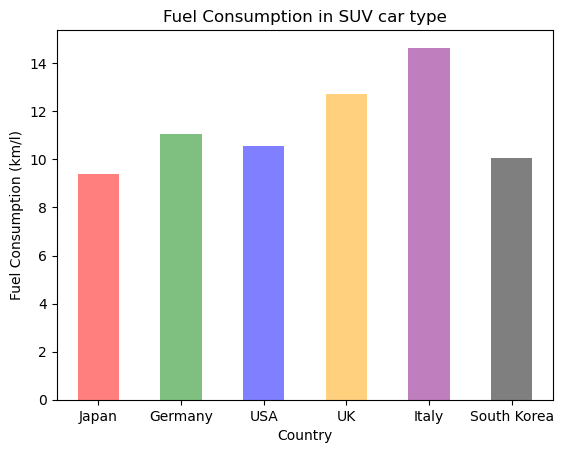

In [28]:
#Plotting chart for Fuel Consumption in SUV car type in every country
car_types_df.plot(kind = 'bar', x = 'Country', y = 'SUV Fuel Consumption', color=['red', 'green', 'blue', 'orange', 'purple','black'], alpha = 0.5, 
               xlabel = 'Country', ylabel = 'Fuel Consumption (km/l)', title = 'Fuel Consumption in SUV car type')
plt.xticks(rotation=0)
plt.legend().remove()
plt.show()

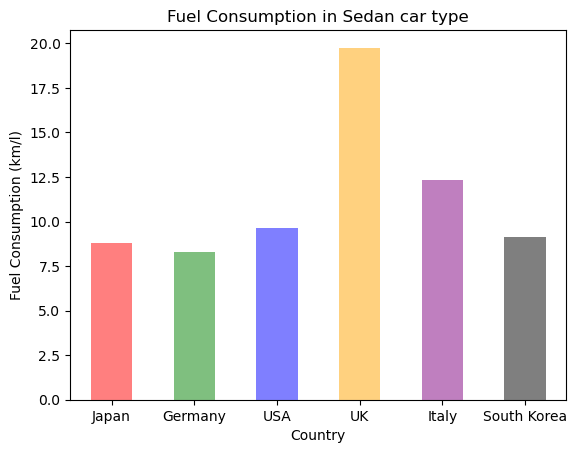

In [29]:
#Plotting chart for Fuel Consumption in Sedan car type in every country
car_types_df.plot(kind = 'bar', x = 'Country', y = 'Sedan Fuel Consumption', color=['red', 'green', 'blue', 'orange', 'purple','black'], alpha = 0.5, 
               xlabel = 'Country', ylabel = 'Fuel Consumption (km/l)', title = 'Fuel Consumption in Sedan car type')
plt.xticks(rotation=0)
plt.legend().remove()
plt.show()

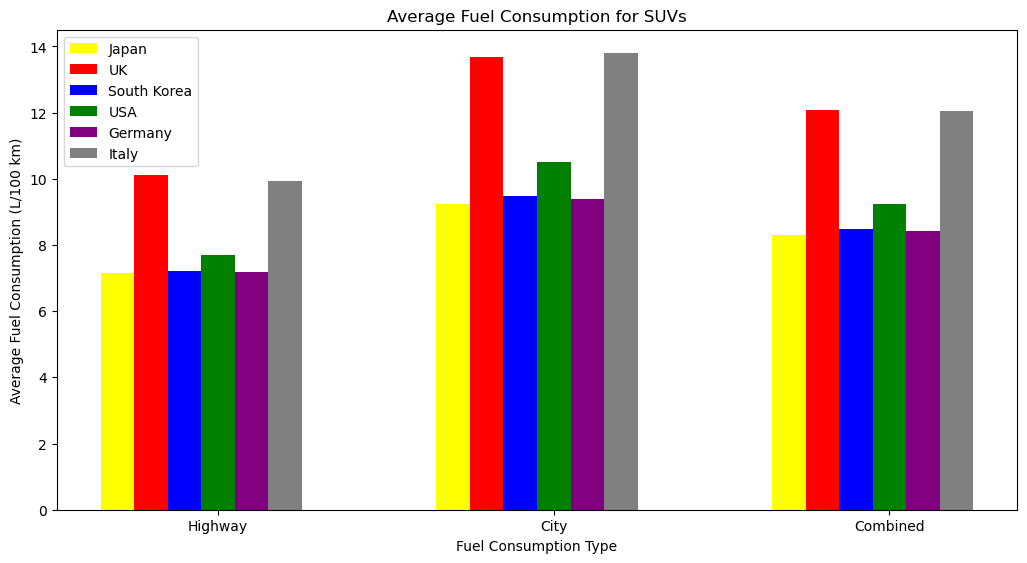

In [30]:
# Data for Japan
japan_suv_highway = final_tweak_df[final_tweak_df['COUNTRY']== "Japan"]['HWY (L/100 km)'].mean()
japan_suv_city = final_tweak_df[final_tweak_df['COUNTRY']== "Japan"]['FUEL CONSUMPTION'].mean()
japan_suv_combined = final_tweak_df[final_tweak_df['COUNTRY']== "Japan"]['COMB (L/100 km)'].mean()

# Data for UK
uk_suv_highway = final_tweak_df[final_tweak_df['COUNTRY'] == "UK"]['HWY (L/100 km)'].mean()
uk_suv_city = final_tweak_df[final_tweak_df['COUNTRY'] == "UK"]['FUEL CONSUMPTION'].mean()
uk_suv_combined = final_tweak_df[final_tweak_df['COUNTRY'] == "UK"]['COMB (L/100 km)'].mean()

# Data for South Korea
korea_suv_highway = final_tweak_df[final_tweak_df['COUNTRY'] == "South Korea"]['HWY (L/100 km)'].mean()
korea_suv_city = final_tweak_df[final_tweak_df['COUNTRY'] == "South Korea"]['FUEL CONSUMPTION'].mean()
korea_suv_combined = final_tweak_df[final_tweak_df['COUNTRY'] == "South Korea"]['COMB (L/100 km)'].mean()

# Data for USA
us_suv_highway = final_tweak_df[final_tweak_df['COUNTRY'] == "USA"]['HWY (L/100 km)'].mean()
us_suv_city = final_tweak_df[final_tweak_df['COUNTRY'] == "USA"]['FUEL CONSUMPTION'].mean()
us_suv_combined = final_tweak_df[final_tweak_df['COUNTRY'] == "USA"]['COMB (L/100 km)'].mean()

# Data for Germany
ger_suv_highway = final_tweak_df[final_tweak_df['COUNTRY'] == "Germany"]['HWY (L/100 km)'].mean()
ger_suv_city = final_tweak_df[final_tweak_df['COUNTRY'] == "Germany"]['FUEL CONSUMPTION'].mean()
ger_suv_combined = final_tweak_df[final_tweak_df['COUNTRY'] == "Germany"]['COMB (L/100 km)'].mean()

# Data for Italy
italy_suv_highway = final_tweak_df[final_tweak_df['COUNTRY'] == "Italy"]['HWY (L/100 km)'].mean()
italy_suv_city = final_tweak_df[final_tweak_df['COUNTRY'] == "Italy"]['FUEL CONSUMPTION'].mean()
italy_suv_combined = final_tweak_df[final_tweak_df['COUNTRY'] == "Italy"]['COMB (L/100 km)'].mean()

# Data for all countries
fuel_types = ['Highway', 'City', 'Combined']
japan_fuel_consumptions = [japan_suv_highway, japan_suv_city, japan_suv_combined]
uk_fuel_consumptions = [uk_suv_highway, uk_suv_city, uk_suv_combined]
korea_fuel_consumptions = [korea_suv_highway, korea_suv_city, korea_suv_combined]
us_fuel_consumptions = [us_suv_highway, us_suv_city, us_suv_combined]
ger_fuel_consumptions = [ger_suv_highway, ger_suv_city, ger_suv_combined]
italy_fuel_consumptions = [italy_suv_highway, italy_suv_city, italy_suv_combined]


# Set the width of the bars
bar_width = 0.1
fig, ax = plt.subplots(figsize=(12, 6))

# Set the positions of the bars on the x-axis
r1 = np.arange(len(fuel_types))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]

# Create the grouped bar chart
plt.bar(r1, japan_fuel_consumptions, color='yellow', width=bar_width, label='Japan')
plt.bar(r2, uk_fuel_consumptions, color='red', width=bar_width, label='UK')
plt.bar(r3, korea_fuel_consumptions, color='blue', width=bar_width, label='South Korea')
plt.bar(r4, us_fuel_consumptions, color='green', width=bar_width, label='USA')
plt.bar(r5, ger_fuel_consumptions, color='purple', width=bar_width, label='Germany')
plt.bar(r6, italy_fuel_consumptions, color='grey', width=bar_width, label='Italy')

# Set axis labels, title, and ticks
plt.xlabel('Fuel Consumption Type')
plt.ylabel('Average Fuel Consumption (L/100 km)')
plt.title('Average Fuel Consumption for SUVs')
ax.set_xticks([r + 3 * bar_width for r in range(len(fuel_types))])
ax.set_xticklabels(fuel_types)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1) 

# Add legend
plt.legend()

# Show the chart
plt.show()

In [31]:
# ANOVA
# NULL HYPOTHESIS: THERE IS NO RELATIONSHIP BETWEEN ENGINE SIZE AND EMISSIONS.
# ALTERNATE HYPOTHESIS: THERE IS A RELATIONSHIP BETWEEN ENGINE SIZE AND EMISSIONS.

In [32]:
emission = final_tweak_df.groupby('ENGINE SIZE')['EMISSIONS'].mean()
result = stats.f_oneway(emission.values, emission.index.values)
result


F_onewayResult(statistic=504.1387950918639, pvalue=4.758731823734792e-32)

Discussion: Since the Pvalue is very low pvalue=4.758731823734792e-32, indicating that the engine and emissions have a strong relationship between each other. Hence, we are rejecting the null hypothesis.

In [33]:
#regressional analysis to confirm relationship between engine size and emission
def linear_regression_plot(x,y,x_cord,y_cord,y_label):

    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    regress_values = x * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x,y)
    plt.plot(x,regress_values,"r-")
    plt.xlabel("ENGINE SIZE (L)")
    plt.ylabel(f'{y_label}')
    plt.grid()
    print(f'The r-square is {rvalue}')
    print(line_eq)
    plt.annotate(line_eq,(x_cord,y_cord),fontsize=12,color="red")

The r-square is 0.782646091967873
y = 33.55x + 130.42


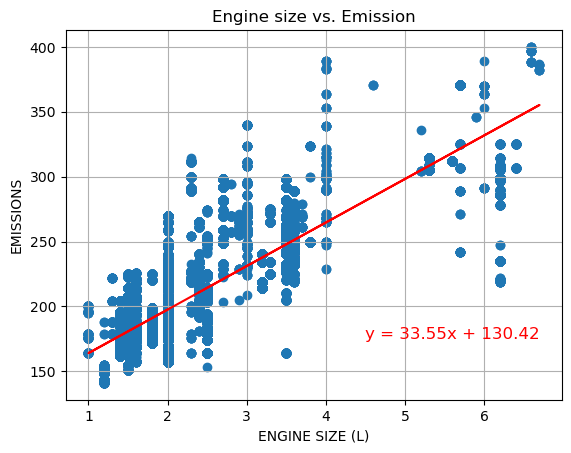

In [34]:
#engine_size vs emissions
x = final_tweak_df['ENGINE SIZE']
y = final_tweak_df['EMISSIONS']
y_label = "EMISSIONS"
x_cord = 4.5
y_cord = 175
linear_regression_plot(x,y,x_cord,y_cord,y_label)
# Set a title
plt.title(f"Engine size vs. Emission")
plt.show()


There is direct relationship between engine size and emissions. As engine size increases the emissions also increase.

In [35]:
#API section - to be able to plot the different countires of car companies that give respective emission.
#Step 1 - create a table to retrieve latitude and longitude
emission_grp = final_tweak_df.groupby('COUNTRY')
emission_grp_mean = round(emission_grp['EMISSIONS'].mean())
emission_grp_count = emission_grp['MODEL'].count()
emission_grp_df = pd.DataFrame({ "EMISSIONS" : emission_grp_mean,
                                "No of cars": emission_grp_count})
emission_grp_df["LATITUDE"] = ""
emission_grp_df["LONGITUDE"] = ""
emission_grp_df["COUNTRY"] = emission_grp_df.index.values
emission_grp_df.reset_index(inplace= True,drop = True)
emission_grp_df["COUNTRY"] = emission_grp_df['COUNTRY'].replace({"UK": "United Kingdom"})
emission_grp_df

,EMISSIONS,No of cars,LATITUDE,LONGITUDE,COUNTRY
0,196.0,11835,,,Germany
1,283.0,109,,,Italy
2,194.0,34979,,,Japan
3,200.0,27284,,,South Korea
4,285.0,378,,,United Kingdom
5,217.0,42629,,,USA


In [36]:
# perform API to retrieve latitude and longitude from Geoapify
base_url = "https://api.geoapify.com/v1/geocode/search"
params = {
    "apiKey":geoapify_key,
    "format":"json"
}
for index, row in emission_grp_df.iterrows():
    country = row["COUNTRY"]
    params["text"] = f"{country}"
    response = requests.get(base_url, params=params)
    response = response.json()
    emission_grp_df.loc[index,"LATITUDE"] = response["results"][0]["lat"]
    emission_grp_df.loc[index,"LONGITUDE"] = response["results"][0]["lon"]  
emission_grp_df

,EMISSIONS,No of cars,LATITUDE,LONGITUDE,COUNTRY
0,196.0,11835,51.163818,10.447831,Germany
1,283.0,109,42.638426,12.674297,Italy
2,194.0,34979,36.574844,139.239418,Japan
3,200.0,27284,36.638392,127.696119,South Korea
4,285.0,378,54.702354,-3.276575,United Kingdom
5,217.0,42629,39.78373,-100.445882,USA


In [37]:
# Plot the dataframe data on a map using hvplot
map_plot_2 = emission_grp_df.hvplot.points(
    "LONGITUDE",
    "LATITUDE",
    geo = True,
    tiles = "EsriNatGeo",
    frame_width = 800,
    frame_height = 500,
    color =  "COUNTRY",
    size = "EMISSIONS"   
)

# Display the map plot
map_plot_2

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [LONGITUDE,LATITUDE]   (COUNTRY,EMISSIONS)